Fitting 5 folds for each of 72 candidates, totalling 360 fits


c:\Users\gavin\miniconda3\envs\data7001\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:41:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Best Hyperparameters:
{'xgb__colsample_bytree': 1.0, 'xgb__learning_rate': 0.3, 'xgb__max_depth': 8, 'xgb__n_estimators': 200, 'xgb__subsample': 1.0}

=== Classification Report (Test Set) ===
              precision    recall  f1-score   support

           0       0.90      0.80      0.85      3738
           1       0.88      0.93      0.90      9432
           2       0.89      0.84      0.86      4251

    accuracy                           0.88     17421
   macro avg       0.89      0.86      0.87     17421
weighted avg       0.88      0.88      0.88     17421


Accuracy (Test Set): 0.8829


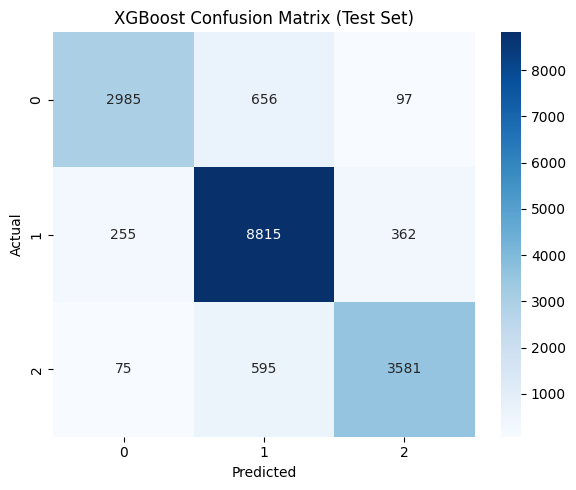

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# === Load and prepare data ===
df_sensor = pd.read_csv("datasets/assignTTSWING_sensor_only.csv")
df_sensor['playYears'] = df_sensor['playYears'].astype(int)

X = df_sensor.drop(columns=['playYears'])
y = df_sensor['playYears']
classes = np.unique(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# === Define pipeline ===
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', XGBClassifier(
        objective='multi:softprob',  # enable predict_proba
        eval_metric='mlogloss',
        use_label_encoder=False,
        num_class=3,
        random_state=42,
        n_jobs=-1
    ))
])

# === Define parameter grid ===
param_grid = {
    'xgb__n_estimators': [100, 200, 300],
    'xgb__max_depth': [6, 8, 10],
    'xgb__learning_rate': [0.1, 0.3, 0.5],
    'xgb__subsample': [0.8, 1.0, 1.2],
    'xgb__colsample_bytree': [0.8, 1.0, 1.2]
}

# === GridSearchCV ===
grid = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    scoring='f1_macro',  # use 'accuracy' if preferred
    cv=5,
    verbose=2,
    n_jobs=-1
)

grid.fit(X_train, y_train)
print("\nBest Hyperparameters:")
print(grid.best_params_)

# === Predict on test set using best estimator ===
best_model = grid.best_estimator_
probs = best_model.predict_proba(X_test)
y_pred = np.argmax(probs, axis=1)

# === Evaluation ===
print("\n=== Classification Report (Test Set) ===")
print(classification_report(y_test, y_pred))

accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy (Test Set): {accuracy:.4f}")

# === Confusion Matrix ===
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.title("XGBoost Confusion Matrix (Test Set)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


In [19]:
print("Unique playYears values:", df_sensor['playYears'].unique())


Unique playYears values: [2 1 0]


In [20]:
print("Class distribution:\n", y.value_counts())


Class distribution:
 playYears
1    47158
2    21255
0    18688
Name: count, dtype: int64


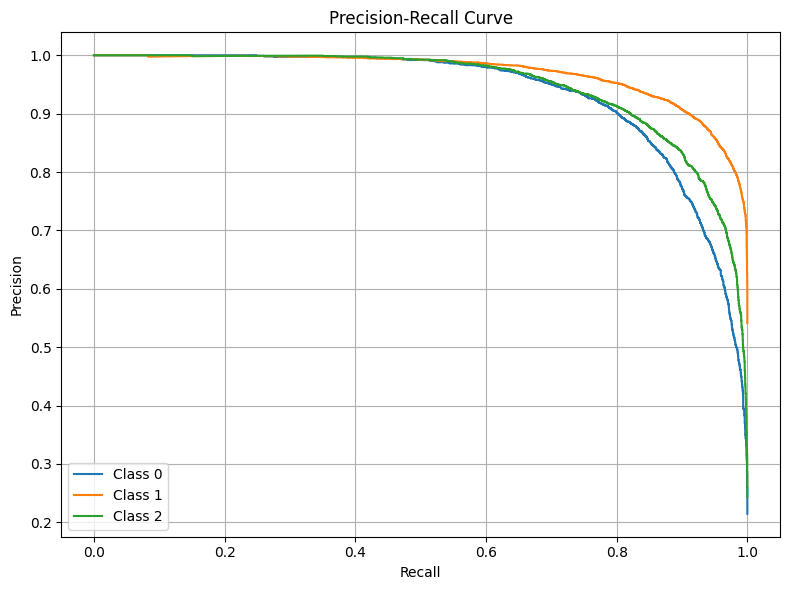

In [22]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve, average_precision_score

y_test_bin = label_binarize(y_test, classes=classes)
n_classes = len(classes)

plt.figure(figsize=(8, 6))
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], probs[:, i])
    plt.plot(recall, precision, label=f'Class {classes[i]}')

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


c:\Users\gavin\miniconda3\envs\data7001\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
4 fits failed out of a total of 25.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\gavin\miniconda3\envs\data7001\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\gavin\miniconda3\envs\data7001\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\gavin\miniconda3\envs\data7001\Lib\site-packages\sklearn\pi

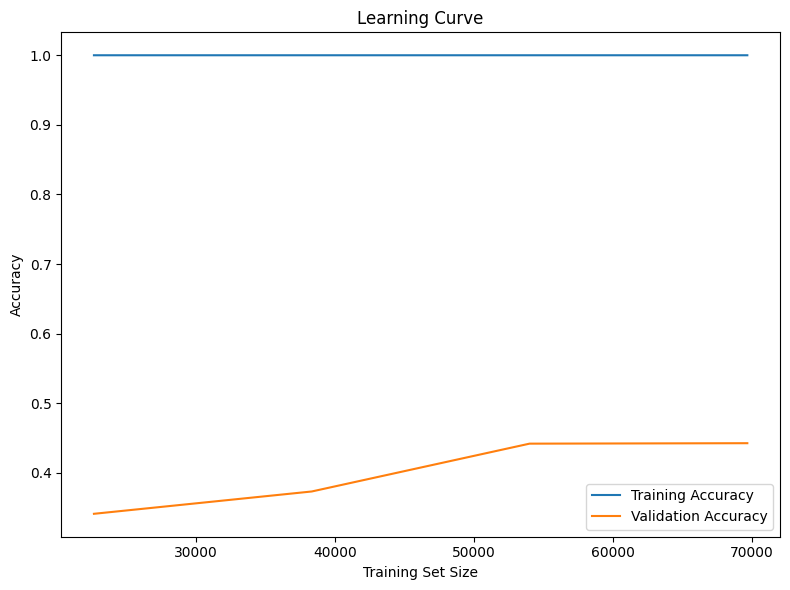

In [24]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    best_model, X, y, cv=5, scoring='accuracy', n_jobs=-1
)

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, label="Training Accuracy")
plt.plot(train_sizes, test_mean, label="Validation Accuracy")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.title("Learning Curve")
plt.legend()
plt.tight_layout()
plt.show()


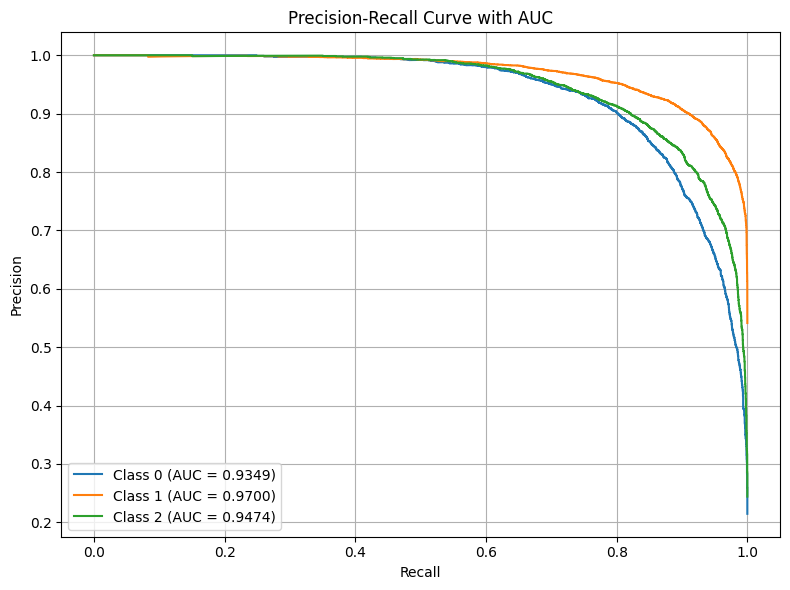

In [28]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Binarize the test labels
y_test_bin = label_binarize(y_test, classes=classes)
n_classes = len(classes)

# Predict probabilities
probs = best_model.predict_proba(X_test)

# Store AUCs
auc_scores = []

# Plot PR curves
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], probs[:, i])
    auc_score = average_precision_score(y_test_bin[:, i], probs[:, i])
    auc_scores.append(auc_score)
    plt.plot(recall, precision, label=f'Class {classes[i]} (AUC = {auc_score:.4f})')

# Labels and layout
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve with AUC")
plt.legend(loc='lower left')
plt.grid(True)

# # Add AUC text box below legend
# auc_text = "\n".join([f"Class {classes[i]} AUC: {auc_scores[i]:.4f}" for i in range(n_classes)])
# plt.text(1.05, 0.5, auc_text, transform=plt.gca().transAxes,
#          fontsize=10, verticalalignment='center', bbox=dict(boxstyle="round", facecolor='white', edgecolor='gray'))

plt.tight_layout()
plt.show()
